In [ ]:
# Required Libraries
%pip install -q qiskit[visualization]
%pip install -q qiskit_aer
%pip install -q qiskit_ibm_runtime
%pip install -q matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import random
import re
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator

# Augmented BBM92 Protocol

## Simulation Without the Presence of an Eavesdropper

### Creating the singlet state

In the first step Alice and Bob receive their qubits of the singlet states $\lvert\psi_s\rangle$ created by Charlie.

For our simulation, we need registers with two quantum bits and four classical bits.

In [4]:
# Creating registers
qr = QuantumRegister(2, name="qr")
cr = ClassicalRegister(4, name="cr")

Let us assume that qubits *qr\[0\]* and *qr\[1\]* belong to Alice and Bob respetively.
In classical bits *cr\[0\]* and *cr\[1\]* Alice and Bob store their measurement results, and classical bits *cr\[2\]* and *cr\[3\]* are used by Eve to store her measurement results of Alice's and Bob's qubits.

Now Charlie creates a singlet state:

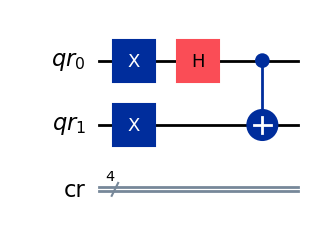

In [5]:
singlet = QuantumCircuit(qr, cr, name='singlet')
singlet.x(qr[0])
singlet.x(qr[1])
singlet.h(qr[0])
singlet.cx(qr[0],qr[1])

singlet.draw('mpl')

### Measurement Circuits

\begin{align*}
b_i = 1: \quad \vec{a}_1 = (1, 0, 0) \quad (X\text{ observable}) \qquad &
b_i = 2: \quad \vec{a}_2 = (0, 0, 1) \quad (Z\text{ observable})
\\
b_j' = 1: \quad \vec{b}_1 = (1, 0, 0) \quad (X\text{ observable}) \qquad &
b_j' = 2: \quad \vec{b}_2 = (0, 0, 1) \quad (Z\text{ observable})
\\
b_j' = 3: \quad \vec{b}_3 = \left(\frac{1}{\sqrt{2}}, 0, \frac{1}{\sqrt{2}}\right) \quad (W\text{ observable}) \qquad &
b_j' = 4: \quad \vec{b}_4 = \left(-\frac{1}{\sqrt{2}}, 0, \frac{1}{\sqrt{2}}\right) \quad (V\text{ observable})
\\
\end{align*}


In [6]:
## Alice's measurement circuits

# measure the spin projection of Alice's qubit onto the a_1 direction (X basis)
measureA1 = QuantumCircuit(qr, cr, name='measureA1')
measureA1.h(qr[0])
measureA1.measure(qr[0],cr[0])

# measure the spin projection of Alice's qubit onto the a_2 direction (standard Z basis)
measureA2 = QuantumCircuit(qr, cr, name='measureA2')
measureA2.measure(qr[0],cr[0])

## Bob's measurement circuits

# Key Generation Bases

# measure the spin projection of Bob's qubit onto the b_1 direction (X basis)
measureB1 = QuantumCircuit(qr, cr, name='measureB1')
measureB1.h(qr[1])
measureB1.measure(qr[1],cr[1])

# measure the spin projection of Bob's qubit onto the b_2 direction (standard Z basis)
measureB2 = QuantumCircuit(qr, cr, name='measureB2')
measureB2.measure(qr[1],cr[1])

# CHSH Value Calculation Bases

# measure the spin projection of Bob's qubit onto the b_3 direction (W basis)
measureB3 = QuantumCircuit(qr, cr, name='measureB3')
measureB3.s(qr[1])
measureB3.h(qr[1])
measureB3.t(qr[1])
measureB3.h(qr[1])
measureB3.measure(qr[1],cr[1])

# measure the spin projection of Bob's qubit onto the b_4 direction (V basis)
measureB4 = QuantumCircuit(qr, cr, name='measureB4')
measureB4.s(qr[1])
measureB4.h(qr[1])
measureB4.tdg(qr[1])
measureB4.h(qr[1])
measureB4.measure(qr[1],cr[1])

## Lists of measurement circuits
aliceMeasurements = [measureA1, measureA2]
bobMeasurements = [measureB1, measureB2, measureB3, measureB4]

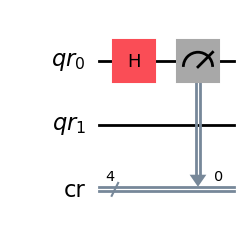

In [7]:
measureA1.draw('mpl')

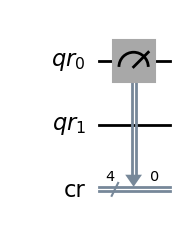

In [8]:
measureA2.draw('mpl')

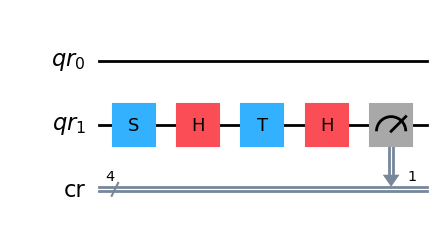

In [9]:
measureB3.draw('mpl')

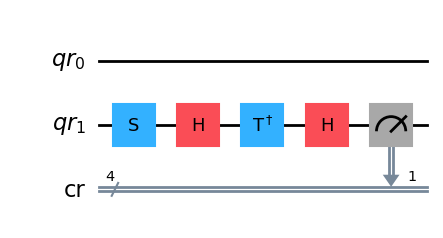

In [10]:
measureB4.draw('mpl')

### QBER Calculation

In [11]:
# QBER Part needs to be added here
def calculate_qber(aliceKey, bobKey, disclose = 10):
    if (len(aliceKey) != len(bobKey)):
        return -1
    key_length = len(aliceKey)
    num_disclosed = max(1, int(np.floor((key_length * disclose/100))))
    disclosed_indices = random.sample(range(key_length), num_disclosed)
    numKeyMismatches = 0
    for i in disclosed_indices:
        if (aliceKey[i] != bobKey[i]):
            numKeyMismatches += 1
    return (numKeyMismatches/num_disclosed) * 100

### CHSH correlation value test

$$C =
\langle X\otimes W \rangle - \langle X \otimes V \rangle + \langle Z \otimes W \rangle + \langle Z \otimes V \rangle =
-2 \sqrt{2}. \qquad\qquad $$

Alice and Bob want to be sure that there was no interference in the communication session.
To do that, they calculate the CHSH correlation value $(3)$ using the results obtained after the measurements of spin projections onto the $\vec{a}_1/\vec{b}_3$, $\vec{a}_1/\vec{b}_4$, $\vec{a}_2/\vec{b}_3$ and $\vec{a}_2/\vec{b}_4$ directions.
Recall that it is equivalent to the measurement of the observables $X \otimes W$, $X \otimes V$, $Z \otimes W$ and $Z \otimes V$ respectively.

$$\langle A(\vec{a}_i) \otimes B(\vec{b}_j) \rangle =
  \mathrm{P}(-1,-1) - \mathrm{P}(1,-1) - \mathrm{P}(-1,1) + \mathrm{P}(1,1). \qquad\qquad$$

$$\mathrm{P}(a_j, b_k) = \frac{n_{a_j, b_k}(A \otimes B)}{N(A \otimes B)} \qquad\qquad$$

In [12]:
# function that calculates CHSH correlation value
def chsh_corr(result, circuits, numberOfSinglets, aliceMeasurementChoices, bobMeasurementChoices, abPatterns):

    # lists with the counts of measurement results
    # each element represents the number of (-1,-1), (1,-1), (-1,1) and (1,1) results respectively
    countA1B3 = [0, 0, 0, 0] # XW observable
    countA1B4 = [0, 0, 0, 0] # XV observable
    countA2B3 = [0, 0, 0, 0] # ZW observable
    countA2B4 = [0, 0, 0, 0] # ZV observable

    for i in range(numberOfSinglets):

        res = list(result.get_counts(circuits[i]).keys())[0]

        # if the spins of the qubits of the i-th singlet were projected onto the a_1/b_3 directions
        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B3[j] += 1
        # if the spins of the qubits of the i-th singlet were projected onto the a_1/b_4 directions
        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 4):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B4[j] += 1
        # if the spins of the qubits of the i-th singlet were projected onto the a_2/b_3 directions
        if (aliceMeasurementChoices[i] == 2 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA2B3[j] += 1

        # if the spins of the qubits of the i-th singlet were projected onto the a_2/b_4 directions
        if (aliceMeasurementChoices[i] == 2 and bobMeasurementChoices[i] == 4):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA2B4[j] += 1

    # number of the results obtained from the measurements in a particular basis
    total13 = sum(countA1B3)
    total14 = sum(countA1B4)
    total23 = sum(countA2B3)
    total24 = sum(countA2B4)

    # expectation values of XW, XV, ZW and ZV observables (2)
    expect13 = (countA1B3[0] - countA1B3[1] - countA1B3[2] + countA1B3[3])/total13 # -1/sqrt(2)
    expect14 = (countA1B4[0] - countA1B4[1] - countA1B4[2] + countA1B4[3])/total14 # 1/sqrt(2)
    expect23 = (countA2B3[0] - countA2B3[1] - countA2B3[2] + countA2B3[3])/total23 # -1/sqrt(2)
    expect24 = (countA2B4[0] - countA2B4[1] - countA2B4[2] + countA2B4[3])/total24 # -1/sqrt(2)

    corr = expect13 - expect14 + expect23 + expect24 # calculate the CHSH correlation value (3)

    return corr

### Function to simulate the protocol without eavesdropping

In [13]:
def bbm92M_without_eavesdropping(numberOfSinglets = 5500, disclose_rate = 11, log = False):
    # Defining Measurement Choices:
    if (log):
        print("Defining Measurement Choices...")
    aliceMeasurementChoices = [random.randint(1, 2) for i in range(numberOfSinglets)] # string b of Alice
    bobMeasurementChoices = [] # string b' of Bob
    bobSignalOrTest = [random.randint(1, 4) for i in range(numberOfSinglets)]
    # (1/4)th = CHSH Test, (3/4)th = Key Generation
    for i in range(len(bobSignalOrTest)):
        if bobSignalOrTest[i] == 1:
            # Test Measurements
            bobMeasurementChoices.append(random.randint(3, 4))
        else:
            # Signal Meaaurements
            bobMeasurementChoices.append(random.randint(1, 2))
    if (log):
        print("Defining Circuits and Applying Measurement Circuits as per the choices...")
    # Circuits
    circuits = []

    for i in range(numberOfSinglets):
        circuitName = f"Singlet{i}: A{aliceMeasurementChoices[i]}_B{bobMeasurementChoices[i]}"
        singletCircuit = singlet.copy()

        # Retrieve Alice's and Bob's measurement circuits
        aliceCircuitMeasurement = aliceMeasurements[aliceMeasurementChoices[i] - 1]
        bobCircuitMeasurement = bobMeasurements[bobMeasurementChoices[i] - 1]

        singletCircuit.barrier()

        # Combine the circuits (assuming sequential composition)
        singletCircuit = singletCircuit.compose(aliceCircuitMeasurement)
        singletCircuit.barrier()
        singletCircuit = singletCircuit.compose(bobCircuitMeasurement)
        singletCircuit.name = circuitName

        # Add the circuit to the list
        circuits.append(singletCircuit)

    if (log):
        print("Measuring Circuits using a backend simulator...")

    backend = AerSimulator()
    job = backend.run(circuits, shots = 1)
    results = job.result()

    abPatterns = [
        re.compile('..00$'), # search for the '..00' output (Alice obtained -1 and Bob obtained -1)
        re.compile('..01$'), # search for the '..01' output (Alice obtained 1 and Bob obtained -1)
        re.compile('..10$'), # search for the '..10' output (Alice obtained -1 and Bob obtained 1)
        re.compile('..11$')  # search for the '..11' output (Alice obtained 1 and Bob obtained 1)
    ]

    if (log):
        print("Analysing Results...")

    aliceResults = []
    bobResults = []

    for i in range(numberOfSinglets):

        res = list(results.get_counts(circuits[i]).keys())[0] # extract the key from the dict and transform it to str; execution result of the i-th circuit

        if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(-1) # Bob got the result -1
        if abPatterns[1].search(res):
            aliceResults.append(1)
            bobResults.append(-1)
        if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(1) # Bob got the result 1
        if abPatterns[3].search(res):
            aliceResults.append(1)
            bobResults.append(1)

    if (log):
        print("Generating the key...")

    aliceKey = []
    bobKey = []

    # comparing the stings with measurement choices
    for i in range(numberOfSinglets):
        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 1) or (aliceMeasurementChoices[i] == 2 and bobMeasurementChoices[i] == 2):
            aliceKey.append(aliceResults[i]) # record the i-th result obtained by Alice as the bit of the secret key k
            bobKey.append(-bobResults[i]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'

    keyLength = len(aliceKey) # length of the secret key

    abKeyMismatches = 0 # number of mismatching bits in Alice's and Bob's keys

    for j in range(keyLength):
        if aliceKey[j] != bobKey[j]:
            abKeyMismatches += 1

    if (log):
        print("Calculating QBER...")

    error_rate = calculate_qber(aliceKey, bobKey)

    if (log):
        print("Calculating Correlation Value...")

    corr = chsh_corr(results, circuits, numberOfSinglets, aliceMeasurementChoices, bobMeasurementChoices, abPatterns) # CHSH correlation value

    if (log):
        print("---------------------")
        print("Protocol Summary: ")
        # Keys
        print(f"Total Number of Qubits Exchanged: " + str(numberOfSinglets))
        print(f"Alice's Key: {aliceKey}")
        print(f"Bob's key: {bobKey}")
        print(f"QBER with disclose rate {disclose_rate}%: {error_rate}")
        print('Length of the key: ' + str(keyLength))
        print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

        # CHSH inequality test
        print('CHSH correlation value: ' + str(round(corr, 3)))

    return keyLength, error_rate, corr

In [14]:
result = bbm92M_without_eavesdropping(log=True)

Defining Measurement Choices...
Defining Circuits and Applying Measurement Circuits as per the choices...
Measuring Circuits using a backend simulator...
Analysing Results...
Generating the key...
Calculating QBER...
Calculating Correlation Value...
---------------------
Protocol Summary: 
Total Number of Qubits Exchanged: 5500
Alice's Key: [-1, 1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1

## Simulation of eavesdropping

### Measurement Circuits

In [15]:
# measurement of the spin projection of Alice's qubit onto the a_1 direction (X basis)
measureEA1 = QuantumCircuit(qr, cr, name='measureEA1')
measureEA1.h(qr[0])
measureEA1.measure(qr[0],cr[2])

# measurement of the spin projection of Alice's qubit onto the a_2 direction (standard Z basis)
measureEA2 = QuantumCircuit(qr, cr, name='measureEA3')
measureEA2.measure(qr[0],cr[2])

# measurement of the spin projection of Bob's qubit onto the b_1 direction (X basis)
measureEB1 = QuantumCircuit(qr, cr, name='measureEB1')
measureEB1.h(qr[1])
measureEB1.measure(qr[1],cr[3])

# measurement of the spin projection of Bob's qubit onto the b_2 direction (standard Z basis)
measureEB2 = QuantumCircuit(qr, cr, name='measureEB2')
measureEB2.measure(qr[1],cr[3])

# lists of measurement circuits
eveMeasurements = [measureEA1, measureEA2, measureEB1, measureEB2]

### Function to simulate the protocol with eavesdropping

In [16]:
def bbm92M_with_eavesdropping(numberOfSinglets = 5500, disclose_rate = 11, qber_threshold = 0.11, log = False):
    # Defining Measurement Choices:
    if (log):
        print("Defining Measurement Choices...")

    aliceMeasurementChoices = [random.randint(1, 2) for i in range(numberOfSinglets)] # string b of Alice
    bobMeasurementChoices = [] # string b' of Bob
    bobSignalOrTest = [random.randint(1, 4) for i in range(numberOfSinglets)]
    # (1/4)th = CHSH Test, (3/4)th = Key Generation
    for i in range(len(bobSignalOrTest)):
        if bobSignalOrTest[i] == 1:
            # Test Measurements
            bobMeasurementChoices.append(random.randint(3, 4))
        else:
            # Signal Meaaurements
            bobMeasurementChoices.append(random.randint(1, 2))

    if (log):
        print("Defining Circuits and Applying Measurement Circuits as per the choices...")

    # Circuits
    ABECircuits = []
    attack_probability = 4 * qber_threshold
    num_intercepts = 0
    intercepted_qubit_indices = []

    for j in range(numberOfSinglets):
        eveMeasurementChoices = []
        SingletCircuitABE = singlet.copy()
        eve_intercepts = np.random.rand() < attack_probability
        if (eve_intercepts):
            num_intercepts += 1
            intercepted_qubit_indices.append(j)
            if random.uniform(0, 1) <= 0.5: # in 50% of cases perform the XX measurement
                eveMeasurementChoices.append([0, 2])
            else:
                eveMeasurementChoices.append([1, 3])
            SingletCircuitABE.barrier()
            SingletCircuitABE = SingletCircuitABE.compose(eveMeasurements[eveMeasurementChoices[0][0]])
            SingletCircuitABE.barrier()
            SingletCircuitABE = SingletCircuitABE.compose(eveMeasurements[eveMeasurementChoices[0][1]])
            SingletCircuitABE.barrier()
            circuitName = f"SingletABE{j}:A{aliceMeasurementChoices[j]}_B{bobMeasurementChoices[j]}_E{eveMeasurementChoices[0][0]}{eveMeasurementChoices[0][1]}"
        else:
            circuitName = f"SingletABE{j}:A{aliceMeasurementChoices[j]}_B{bobMeasurementChoices[j]}_NoEavesdropping"

        SingletCircuitABE = SingletCircuitABE.compose(aliceMeasurements[aliceMeasurementChoices[j] - 1])
        SingletCircuitABE.barrier()
        SingletCircuitABE = SingletCircuitABE.compose(bobMeasurements[bobMeasurementChoices[j] - 1])

        SingletCircuitABE.name = circuitName
        # add the created circuit to the circuits list
        ABECircuits.append(SingletCircuitABE)

    if (log):
        print("Measuring Circuits using a backend simulator...")

    backend = AerSimulator()
    Eavesdropping_results = backend.run(ABECircuits, shots = 1).result()

    ePatterns = [
        re.compile('00..$'), # search for the '00..' result (Eve obtained the results -1 and -1 for Alice's and Bob's qubits)
        re.compile('01..$'), # search for the '01..' result (Eve obtained the results 1 and -1 for Alice's and Bob's qubits)
        re.compile('10..$'), # search for the '10..' result (Eve obtained the results -1 and 1 for Alice's and Bob's qubits)
        re.compile('11..$')  # search for the '11..' result (Eve obtained the results 1 and 1 for Alice's and Bob's qubits)
    ]

    abPatterns = [
        re.compile('..00$'), # search for the '..00' output (Alice obtained -1 and Bob obtained -1)
        re.compile('..01$'), # search for the '..01' output (Alice obtained 1 and Bob obtained -1)
        re.compile('..10$'), # search for the '..10' output (Alice obtained -1 and Bob obtained 1)
        re.compile('..11$')  # search for the '..11' output (Alice obtained 1 and Bob obtained 1)
    ]

    if (log):
        print("Analysing Results...")

    aliceResults = []
    bobResults = []
    eveResults = []

    for j in range(numberOfSinglets):
        res = list(Eavesdropping_results.get_counts(ABECircuits[j]).keys())[0] # extract a key from the dict and transform it to str
        # Alice and Bob
        if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(-1) # Bob got the result -1
        if abPatterns[1].search(res): # check if the key is '..01' (if the measurement results are 1,-1)
            aliceResults.append(1)
            bobResults.append(-1)
        if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(1) # Bob got the result 1
        if abPatterns[3].search(res): # check if the key is '..11' (if the measurement results are 1,1)
            aliceResults.append(1)
            bobResults.append(1)

        # Eve
        if ePatterns[0].search(res): # check if the key is '00..'
            eveResults.append([-1, -1]) # results of the measurement of Alice's and Bob's qubits are -1,-1
        if ePatterns[1].search(res): # check if the key is '01..'
            eveResults.append([1, -1]) # results of the measurement of Alice's and Bob's qubits are 1,-1
        if ePatterns[2].search(res): # check if the key is '10..'
            eveResults.append([-1, 1]) # results of the measurement of Alice's and Bob's qubits are -1,1
        if ePatterns[3].search(res): # check if the key is '11..'
            eveResults.append([1, 1]) # results of the measurement of Alice's and Bob's qubits are 1,1

    if (log):
        print("Generating the key...")

    aliceKey = [] # Alice's key string a
    bobKey = [] # Bob's key string a'
    eveKeys = [] # Eve's keys; the 1-st column is the key of Alice, and the 2-nd is the key of Bob

    keyIndices = [] # Indices of Qubits used for the key
    key_index_with_intercepted_qubit = [] # Indices of Alice's and Bob's Key which was formed using the qubits that was intercepted by Eve
    idx = 0
    # comparing the strings with measurement choices (b and b')
    for j in range(numberOfSinglets):
        # if Alice and Bob measured the spin projections onto the a_2/b_1 or a_3/b_2 directions
        if (aliceMeasurementChoices[j] == 1 and bobMeasurementChoices[j] == 1) or (aliceMeasurementChoices[j] == 2 and bobMeasurementChoices[j] == 2):
            keyIndices.append(j)
            if j in intercepted_qubit_indices:
                key_index_with_intercepted_qubit.append(idx)
                eveKeys.append([eveResults[j][0], -eveResults[j][1]]) # record the i-th bits of the keys of Eve
            aliceKey.append(aliceResults[j]) # record the i-th result obtained by Alice as the bit of the secret key k
            bobKey.append(-bobResults[j]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'
            idx += 1

    keyLength = len(aliceKey) # length of the secret key

    if (log):
        print("Calculating Key Mismatches...")

    abKeyMismatches = 0 # number of mismatching bits in the keys of Alice and Bob
    eaKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Alice
    ebKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Bob

    for j in range(keyLength):
        if aliceKey[j] != bobKey[j]:
            abKeyMismatches += 1

    for j in range(len(key_index_with_intercepted_qubit)):
        if eveKeys[j][0] != aliceKey[key_index_with_intercepted_qubit[j]]:
            eaKeyMismatches += 1
        if eveKeys[j][1] != bobKey[key_index_with_intercepted_qubit[j]]:
            ebKeyMismatches += 1

    num_intercepts_used_in_key = len(key_index_with_intercepted_qubit);

    if (log):
        print("Calculating Eve's Knowledge of Alice's and Bob's Keys...")
    eaKnowledge = (num_intercepts_used_in_key - eaKeyMismatches)/num_intercepts_used_in_key # Eve's knowledge of Alice's key
    ebKnowledge = (num_intercepts_used_in_key - ebKeyMismatches)/num_intercepts_used_in_key # Eve's knowledge of Bob's key

    if (log):
        print("Calculating QBER...")
    error_rate = calculate_qber(aliceKey, bobKey)

    if (log):
        print("Calculating Correlation Value...")
    corr = chsh_corr(Eavesdropping_results, ABECircuits, numberOfSinglets, aliceMeasurementChoices, bobMeasurementChoices, abPatterns) # CHSH correlation value

    if (log):
        print("---------------------")
        print("Protocol Summary: ")
        print("Number of Qubits: " + str(numberOfSinglets))
        # Keys
        print('Length of the key: ' + str(keyLength))
        print('Number of mismatching bits: ' + str(abKeyMismatches))
        print(f"QBER with disclose rate of {disclose_rate}%: {error_rate}" + '\n')

        print('Number of qubits intercepted: ' + str(num_intercepts))
        print('Number of intercepted qubits used in the key: ' + str(num_intercepts_used_in_key) + "\n")

        # CHSH inequality test
        print('CHSH correlation value: ' + str(round(corr, 3)) + '\n')

        print('Eve Alice Key mismatches: ' + str(eaKeyMismatches))
        print('Eve Bob Key mismatches: ' + str(ebKeyMismatches) + '\n')

        print('Eve\'s knowledge of Alice\'s key: ' + str(round(eaKnowledge * 100, 2)) + ' %')
        print('Eve\'s knowledge of Bob\'s key: ' + str(round(ebKnowledge * 100, 2)) + ' %')

    return keyLength, error_rate, corr, eaKnowledge, ebKnowledge, num_intercepts_used_in_key, eaKeyMismatches, ebKeyMismatches, abKeyMismatches, num_intercepts


In [17]:
result = bbm92M_with_eavesdropping(numberOfSinglets=4000, log=True)

Defining Measurement Choices...
Defining Circuits and Applying Measurement Circuits as per the choices...
Measuring Circuits using a backend simulator...
Analysing Results...
Generating the key...
Calculating Key Mismatches...
Calculating Eve's Knowledge of Alice's and Bob's Keys...
Calculating QBER...
Calculating Correlation Value...
---------------------
Protocol Summary: 
Number of Qubits: 4000
Length of the key: 1519
Number of mismatching bits: 174
QBER with disclose rate of 11%: 13.90728476821192

Number of qubits intercepted: 1749
Number of intercepted qubits used in the key: 655

CHSH correlation value: -2.056

Eve Alice Key mismatches: 183
Eve Bob Key mismatches: 175

Eve's knowledge of Alice's key: 72.06 %
Eve's knowledge of Bob's key: 73.28 %


### Metrics for Graphs

In [18]:
number_of_qubits = np.linspace(1000, 6000, 11)
bbm92M_abMismatches = []
bbm92M_num_intercepted_and_in_key = []
bbm92M_eaMismatches = []
bbm92M_ebMismatches = []
bbm92M_keyLengths = []
eve_alice_knowledge = []
eve_bob_knowledge = []
bbm92M_num_intercepts = []
for i in range(len(number_of_qubits)):
    result = bbm92M_with_eavesdropping(numberOfSinglets=int(number_of_qubits[i]))
    eve_alice_knowledge.append(result[3])
    eve_bob_knowledge.append(result[4])
    bbm92M_num_intercepted_and_in_key.append(result[5])
    bbm92M_eaMismatches.append(result[6])
    bbm92M_ebMismatches.append(result[7])
    bbm92M_keyLengths.append(result[0])
    bbm92M_abMismatches.append(result[8])
    bbm92M_num_intercepts.append(result[9])
    print(f"Circuit {i} done")

Circuit 0 done
Circuit 1 done
Circuit 2 done
Circuit 3 done
Circuit 4 done
Circuit 5 done
Circuit 6 done
Circuit 7 done
Circuit 8 done
Circuit 9 done
Circuit 10 done


In [19]:
print(f"Number of qubits: {number_of_qubits}")
print(f"Key Lengths: {bbm92M_keyLengths}")
print(f"E-A Mismatches: {bbm92M_eaMismatches}")
print(f"E-B Mismatches: {bbm92M_ebMismatches}")
print(f"A-B Mismatches: {bbm92M_abMismatches}")
print(f"Number of qubits intercepted: {bbm92M_num_intercepts}")
print(f"Number of qubits intercepted by Eve and is in the key: {bbm92M_num_intercepted_and_in_key}")

Number of qubits: [1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500. 5000. 5500. 6000.]
Key Lengths: [348, 551, 722, 970, 1125, 1286, 1458, 1688, 1953, 2057, 2240]
E-A Mismatches: [41, 44, 82, 105, 117, 135, 154, 177, 202, 210, 228]
E-B Mismatches: [36, 62, 69, 110, 108, 123, 147, 167, 210, 198, 240]
A-B Mismatches: [37, 58, 77, 107, 111, 122, 141, 186, 210, 222, 234]
Number of qubits intercepted: [440, 658, 913, 1102, 1315, 1525, 1783, 2005, 2171, 2400, 2594]
Number of qubits intercepted by Eve and is in the key: [152, 233, 327, 418, 493, 525, 671, 752, 838, 864, 987]


# BBM92 Protocol

## Simulation Without the Presence of an Eavesdropper

### Creating the singlet state

In the first step Alice and Bob receive their qubits of the singlet states $\lvert\psi_s\rangle$ created by Charlie.

For our simulation, we need registers with two quantum bits and four classical bits.

In [20]:
# Creating registers
qr = QuantumRegister(2, name="qr")
cr = ClassicalRegister(4, name="cr")

Let us assume that qubits *qr\[0\]* and *qr\[1\]* belong to Alice and Bob respetively.
In classical bits *cr\[0\]* and *cr\[1\]* Alice and Bob store their measurement results, and classical bits *cr\[2\]* and *cr\[3\]* are used by Eve to store her measurement results of Alice's and Bob's qubits.

Now Charlie creates a singlet state:

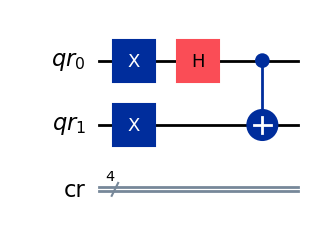

In [21]:
singlet = QuantumCircuit(qr, cr, name='singlet')
singlet.x(qr[0])
singlet.x(qr[1])
singlet.h(qr[0])
singlet.cx(qr[0],qr[1])

singlet.draw('mpl')

### Measurement Circuits

\begin{align*}
b_i = 1: \quad \vec{a}_1 = (1, 0, 0) \quad (X\text{ observable}) \qquad &
b_i = 2: \quad \vec{a}_2 = (0, 0, 1) \quad (Z\text{ observable})
\\
b_j' = 1: \quad \vec{b}_1 = (1, 0, 0) \quad (X\text{ observable}) \qquad &
b_j' = 2: \quad \vec{b}_2 = (0, 0, 1) \quad (Z\text{ observable})
\\
\end{align*}


In [22]:
## Alice's measurement circuits

# measure the spin projection of Alice's qubit onto the a_1 direction (X basis)
measureA1 = QuantumCircuit(qr, cr, name='measureA1')
measureA1.h(qr[0])
measureA1.measure(qr[0],cr[0])

# measure the spin projection of Alice's qubit onto the a_2 direction (standard Z basis)
measureA2 = QuantumCircuit(qr, cr, name='measureA2')
measureA2.measure(qr[0],cr[0])

## Bob's measurement circuits

# Key Generation Bases

# measure the spin projection of Bob's qubit onto the b_1 direction (X basis)
measureB1 = QuantumCircuit(qr, cr, name='measureB1')
measureB1.h(qr[1])
measureB1.measure(qr[1],cr[1])

# measure the spin projection of Bob's qubit onto the b_2 direction (standard Z basis)
measureB2 = QuantumCircuit(qr, cr, name='measureB2')
measureB2.measure(qr[1],cr[1])

## Lists of measurement circuits
aliceMeasurements = [measureA1, measureA2]
bobMeasurements = [measureB1, measureB2]

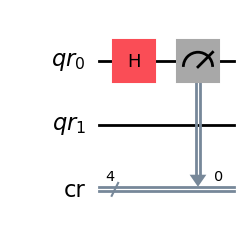

In [23]:
measureA1.draw('mpl')

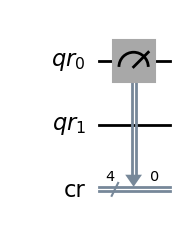

In [24]:
measureA2.draw('mpl')

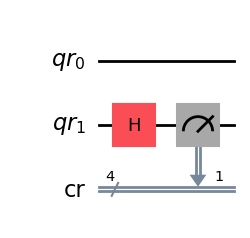

In [25]:
measureB1.draw('mpl')

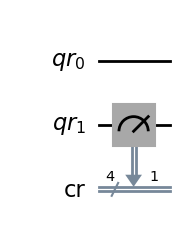

In [26]:
measureB2.draw('mpl')

### QBER Calculation

In [27]:
# QBER Part needs to be added here
def calculate_qber(aliceKey, bobKey, disclose = 10):
    if (len(aliceKey) != len(bobKey)):
        return -1
    key_length = len(aliceKey)
    num_disclosed = max(1, int(np.floor((key_length * disclose/100))))
    disclosed_indices = random.sample(range(key_length), num_disclosed)
    numKeyMismatches = 0
    for i in disclosed_indices:
        if (aliceKey[i] != bobKey[i]):
            numKeyMismatches += 1
    return (numKeyMismatches/num_disclosed) * 100

### Function to simulate the protocol without eavesdropping

In [28]:
def bbm92_without_eavesdropping(numberOfSinglets = 5500, disclose_rate = 11, log = False):
    # Defining Measurement Choices:
    if (log):
        print("Defining Measurement Choices...")
    aliceMeasurementChoices = [random.randint(1, 2) for i in range(numberOfSinglets)] # string b of Alice
    bobMeasurementChoices = [random.randint(1, 2) for i in range(numberOfSinglets)] # string b' of Bob
    if (log):
        print("Defining Circuits and Applying Measurement Circuits as per the choices...")
    # Circuits
    circuits = []

    for i in range(numberOfSinglets):
        circuitName = f"Singlet{i}: A{aliceMeasurementChoices[i]}_B{bobMeasurementChoices[i]}"
        singletCircuit = singlet.copy()

        # Retrieve Alice's and Bob's measurement circuits
        aliceCircuitMeasurement = aliceMeasurements[aliceMeasurementChoices[i] - 1]
        bobCircuitMeasurement = bobMeasurements[bobMeasurementChoices[i] - 1]

        singletCircuit.barrier()

        # Combine the circuits (assuming sequential composition)
        singletCircuit = singletCircuit.compose(aliceCircuitMeasurement)
        singletCircuit.barrier()
        singletCircuit = singletCircuit.compose(bobCircuitMeasurement)
        singletCircuit.name = circuitName

        # Add the circuit to the list
        circuits.append(singletCircuit)

    if (log):
        print("Measuring Circuits using a backend simulator...")

    backend = AerSimulator()
    job = backend.run(circuits, shots = 1)
    results = job.result()

    abPatterns = [
        re.compile('..00$'), # search for the '..00' output (Alice obtained -1 and Bob obtained -1)
        re.compile('..01$'), # search for the '..01' output (Alice obtained 1 and Bob obtained -1)
        re.compile('..10$'), # search for the '..10' output (Alice obtained -1 and Bob obtained 1)
        re.compile('..11$')  # search for the '..11' output (Alice obtained 1 and Bob obtained 1)
    ]

    if (log):
        print("Analysing Results...")

    aliceResults = []
    bobResults = []

    for i in range(numberOfSinglets):

        res = list(results.get_counts(circuits[i]).keys())[0] # extract the key from the dict and transform it to str; execution result of the i-th circuit

        if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(-1) # Bob got the result -1
        if abPatterns[1].search(res):
            aliceResults.append(1)
            bobResults.append(-1)
        if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(1) # Bob got the result 1
        if abPatterns[3].search(res):
            aliceResults.append(1)
            bobResults.append(1)

    if (log):
        print("Generating the key...")

    aliceKey = []
    bobKey = []

    # comparing the stings with measurement choices
    for i in range(numberOfSinglets):
        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 1) or (aliceMeasurementChoices[i] == 2 and bobMeasurementChoices[i] == 2):
            aliceKey.append(aliceResults[i]) # record the i-th result obtained by Alice as the bit of the secret key k
            bobKey.append(-bobResults[i]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'

    keyLength = len(aliceKey) # length of the secret key

    abKeyMismatches = 0 # number of mismatching bits in Alice's and Bob's keys

    for j in range(keyLength):
        if aliceKey[j] != bobKey[j]:
            abKeyMismatches += 1

    if (log):
        print("Calculating QBER...")

    error_rate = calculate_qber(aliceKey, bobKey)

    if (log):
        print("---------------------")
        print("Protocol Summary: ")
        # Keys
        print(f"Total Number of Qubits Exchanged: " + str(numberOfSinglets))
        print(f"Alice's Key: {aliceKey}")
        print(f"Bob's key: {bobKey}")
        print(f"QBER with disclose rate {disclose_rate}%: {error_rate}")
        print('Length of the key: ' + str(keyLength))
        print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

    return keyLength, error_rate

In [29]:
result = bbm92_without_eavesdropping(log=True)

Defining Measurement Choices...
Defining Circuits and Applying Measurement Circuits as per the choices...
Measuring Circuits using a backend simulator...
Analysing Results...
Generating the key...
Calculating QBER...
---------------------
Protocol Summary: 
Total Number of Qubits Exchanged: 5500
Alice's Key: [-1, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 

## Simulation of eavesdropping

### Measurement Circuits

In [30]:
# measurement of the spin projection of Alice's qubit onto the a_1 direction (X basis)
measureEA1 = QuantumCircuit(qr, cr, name='measureEA1')
measureEA1.h(qr[0])
measureEA1.measure(qr[0],cr[2])

# measurement of the spin projection of Alice's qubit onto the a_2 direction (standard Z basis)
measureEA2 = QuantumCircuit(qr, cr, name='measureEA3')
measureEA2.measure(qr[0],cr[2])

# measurement of the spin projection of Bob's qubit onto the b_1 direction (X basis)
measureEB1 = QuantumCircuit(qr, cr, name='measureEB1')
measureEB1.h(qr[1])
measureEB1.measure(qr[1],cr[3])

# measurement of the spin projection of Bob's qubit onto the b_2 direction (standard Z basis)
measureEB2 = QuantumCircuit(qr, cr, name='measureEB2')
measureEB2.measure(qr[1],cr[3])

# lists of measurement circuits
eveMeasurements = [measureEA1, measureEA2, measureEB1, measureEB2]

### Function for simulation with eavesdropping

In [31]:
def bbm92_with_eavesdropping(numberOfSinglets = 5500, disclose_rate = 11, qber_threshold = 0.11, log = False):
    # Defining Measurement Choices:
    if (log):
        print("Defining Measurement Choices...")

    aliceMeasurementChoices = [random.randint(1, 2) for i in range(numberOfSinglets)] # string b of Alice
    bobMeasurementChoices = [random.randint(1, 2) for i in range(numberOfSinglets)] # string b' of Bob

    if (log):
        print("Defining Circuits and Applying Measurement Circuits as per the choices...")

    # Circuits
    ABECircuits = []
    attack_probability = 4 * qber_threshold
    num_intercepts = 0
    intercepted_qubit_indices = []

    for j in range(numberOfSinglets):
        eveMeasurementChoices = []
        SingletCircuitABE = singlet.copy()
        eve_intercepts = np.random.rand() < attack_probability
        if (eve_intercepts):
            num_intercepts += 1
            intercepted_qubit_indices.append(j)
            if random.uniform(0, 1) <= 0.5: # in 50% of cases perform the XX measurement
                eveMeasurementChoices.append([0, 2])
            else:
                eveMeasurementChoices.append([1, 3])
            SingletCircuitABE.barrier()
            SingletCircuitABE = SingletCircuitABE.compose(eveMeasurements[eveMeasurementChoices[0][0]])
            SingletCircuitABE.barrier()
            SingletCircuitABE = SingletCircuitABE.compose(eveMeasurements[eveMeasurementChoices[0][1]])
            SingletCircuitABE.barrier()
            circuitName = f"SingletABE{j}:A{aliceMeasurementChoices[j]}_B{bobMeasurementChoices[j]}_E{eveMeasurementChoices[0][0]}{eveMeasurementChoices[0][1]}"
        else:
            circuitName = f"SingletABE{j}:A{aliceMeasurementChoices[j]}_B{bobMeasurementChoices[j]}_NoEavesdropping"

        SingletCircuitABE = SingletCircuitABE.compose(aliceMeasurements[aliceMeasurementChoices[j] - 1])
        SingletCircuitABE.barrier()
        SingletCircuitABE = SingletCircuitABE.compose(bobMeasurements[bobMeasurementChoices[j] - 1])

        SingletCircuitABE.name = circuitName
        # add the created circuit to the circuits list
        ABECircuits.append(SingletCircuitABE)

    if (log):
        print("Measuring Circuits using a backend simulator...")

    backend = AerSimulator()
    Eavesdropping_results = backend.run(ABECircuits, shots = 1).result()

    ePatterns = [
        re.compile('00..$'), # search for the '00..' result (Eve obtained the results -1 and -1 for Alice's and Bob's qubits)
        re.compile('01..$'), # search for the '01..' result (Eve obtained the results 1 and -1 for Alice's and Bob's qubits)
        re.compile('10..$'), # search for the '10..' result (Eve obtained the results -1 and 1 for Alice's and Bob's qubits)
        re.compile('11..$')  # search for the '11..' result (Eve obtained the results 1 and 1 for Alice's and Bob's qubits)
    ]

    abPatterns = [
        re.compile('..00$'), # search for the '..00' output (Alice obtained -1 and Bob obtained -1)
        re.compile('..01$'), # search for the '..01' output (Alice obtained 1 and Bob obtained -1)
        re.compile('..10$'), # search for the '..10' output (Alice obtained -1 and Bob obtained 1)
        re.compile('..11$')  # search for the '..11' output (Alice obtained 1 and Bob obtained 1)
    ]

    if (log):
        print("Analysing Results...")

    aliceResults = []
    bobResults = []
    eveResults = []

    for j in range(numberOfSinglets):
        res = list(Eavesdropping_results.get_counts(ABECircuits[j]).keys())[0] # extract a key from the dict and transform it to str
        # Alice and Bob
        if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(-1) # Bob got the result -1
        if abPatterns[1].search(res): # check if the key is '..01' (if the measurement results are 1,-1)
            aliceResults.append(1)
            bobResults.append(-1)
        if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(1) # Bob got the result 1
        if abPatterns[3].search(res): # check if the key is '..11' (if the measurement results are 1,1)
            aliceResults.append(1)
            bobResults.append(1)

        # Eve
        if ePatterns[0].search(res): # check if the key is '00..'
            eveResults.append([-1, -1]) # results of the measurement of Alice's and Bob's qubits are -1,-1
        if ePatterns[1].search(res): # check if the key is '01..'
            eveResults.append([1, -1]) # results of the measurement of Alice's and Bob's qubits are 1,-1
        if ePatterns[2].search(res): # check if the key is '10..'
            eveResults.append([-1, 1]) # results of the measurement of Alice's and Bob's qubits are -1,1
        if ePatterns[3].search(res): # check if the key is '11..'
            eveResults.append([1, 1]) # results of the measurement of Alice's and Bob's qubits are 1,1

    if (log):
        print("Generating the key...")

    aliceKey = [] # Alice's key string a
    bobKey = [] # Bob's key string a'
    eveKeys = [] # Eve's keys; the 1-st column is the key of Alice, and the 2-nd is the key of Bob

    keyIndices = [] # Indices of Qubits used for the key
    key_index_with_intercepted_qubit = [] # Indices of Alice's and Bob's Key which was formed using the qubits that was intercepted by Eve
    idx = 0
    # comparing the strings with measurement choices (b and b')
    for j in range(numberOfSinglets):
        # if Alice and Bob measured the spin projections onto the a_2/b_1 or a_3/b_2 directions
        if (aliceMeasurementChoices[j] == 1 and bobMeasurementChoices[j] == 1) or (aliceMeasurementChoices[j] == 2 and bobMeasurementChoices[j] == 2):
            keyIndices.append(j)
            if j in intercepted_qubit_indices:
                key_index_with_intercepted_qubit.append(idx)
                eveKeys.append([eveResults[j][0], -eveResults[j][1]]) # record the i-th bits of the keys of Eve
            aliceKey.append(aliceResults[j]) # record the i-th result obtained by Alice as the bit of the secret key k
            bobKey.append(-bobResults[j]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'
            idx += 1

    keyLength = len(aliceKey) # length of the secret key

    if (log):
        print("Calculating Key Mismatches...")

    abKeyMismatches = 0 # number of mismatching bits in the keys of Alice and Bob
    eaKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Alice
    ebKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Bob

    for j in range(keyLength):
        if aliceKey[j] != bobKey[j]:
            abKeyMismatches += 1

    for j in range(len(key_index_with_intercepted_qubit)):
        if eveKeys[j][0] != aliceKey[key_index_with_intercepted_qubit[j]]:
            eaKeyMismatches += 1
        if eveKeys[j][1] != bobKey[key_index_with_intercepted_qubit[j]]:
            ebKeyMismatches += 1

    num_intercepts_used_in_key = len(key_index_with_intercepted_qubit);

    if (log):
        print("Calculating Eve's Knowledge of Alice's and Bob's Keys...")
    eaKnowledge = (num_intercepts_used_in_key - eaKeyMismatches)/num_intercepts_used_in_key # Eve's knowledge of Alice's key
    ebKnowledge = (num_intercepts_used_in_key - ebKeyMismatches)/num_intercepts_used_in_key # Eve's knowledge of Bob's key

    if (log):
        print("Calculating QBER...")
    error_rate = calculate_qber(aliceKey, bobKey)

    if (log):
        print("---------------------")
        print("Protocol Summary: ")
        print("Number of Qubits: " + str(numberOfSinglets))
        # Keys
        print('Length of the key: ' + str(keyLength))
        print('Number of mismatching bits: ' + str(abKeyMismatches))
        print(f"QBER with disclose rate of {disclose_rate}%: {error_rate}" + '\n')

        print('Number of qubits intercepted: ' + str(num_intercepts))
        print('Number of intercepted qubits used in the key: ' + str(num_intercepts_used_in_key) + "\n")

        print('Eve Alice Key mismatches: ' + str(eaKeyMismatches))
        print('Eve Bob Key mismatches: ' + str(ebKeyMismatches) + '\n')

        print('Eve\'s knowledge of Alice\'s key: ' + str(round(eaKnowledge * 100, 2)) + ' %')
        print('Eve\'s knowledge of Bob\'s key: ' + str(round(ebKnowledge * 100, 2)) + ' %')

    return keyLength, error_rate, eaKnowledge, ebKnowledge, num_intercepts_used_in_key, eaKeyMismatches, ebKeyMismatches, abKeyMismatches, num_intercepts


In [32]:
result = bbm92_with_eavesdropping(numberOfSinglets=5500, log=True)

Defining Measurement Choices...
Defining Circuits and Applying Measurement Circuits as per the choices...
Measuring Circuits using a backend simulator...
Analysing Results...
Generating the key...
Calculating Key Mismatches...
Calculating Eve's Knowledge of Alice's and Bob's Keys...
Calculating QBER...
---------------------
Protocol Summary: 
Number of Qubits: 5500
Length of the key: 2754
Number of mismatching bits: 315
QBER with disclose rate of 11%: 13.454545454545455

Number of qubits intercepted: 2440
Number of intercepted qubits used in the key: 1216

Eve Alice Key mismatches: 320
Eve Bob Key mismatches: 299

Eve's knowledge of Alice's key: 73.68 %
Eve's knowledge of Bob's key: 75.41 %


### Metrics

In [33]:
number_of_qubits = np.linspace(1000, 6000, 11)
bbm92_abMismatches = []
bbm92_num_intercepted_and_in_key = []
bbm92_eaMismatches = []
bbm92_ebMismatches = []
bbm92_keyLengths = []
eve_alice_knowledge = []
eve_bob_knowledge = []
bbm92_num_intercepts = []
for i in range(len(number_of_qubits)):
    result = bbm92_with_eavesdropping(numberOfSinglets=int(number_of_qubits[i]))
    eve_alice_knowledge.append(result[2])
    eve_bob_knowledge.append(result[3])
    bbm92_num_intercepted_and_in_key.append(result[4])
    bbm92_eaMismatches.append(result[5])
    bbm92_ebMismatches.append(result[6])
    bbm92_keyLengths.append(result[0])
    bbm92_abMismatches.append(result[7])
    bbm92_num_intercepts.append(result[8])
    print(f"Circuit {i} done")

Circuit 0 done
Circuit 1 done
Circuit 2 done
Circuit 3 done
Circuit 4 done
Circuit 5 done
Circuit 6 done
Circuit 7 done
Circuit 8 done
Circuit 9 done
Circuit 10 done


In [34]:
print(f"Number of qubits: {number_of_qubits}")
print(f"Key Lengths: {bbm92_keyLengths}")
print(f"E-A Mismatches: {bbm92_eaMismatches}")
print(f"E-B Mismatches: {bbm92_ebMismatches}")
print(f"A-B Mismatches: {bbm92_abMismatches}")
print(f"Number of qubits intercepted: {bbm92_num_intercepts}")
print(f"Number of qubits intercepted by Eve and is in the key: {bbm92_num_intercepted_and_in_key}")

Number of qubits: [1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500. 5000. 5500. 6000.]
Key Lengths: [496, 725, 1004, 1221, 1454, 1698, 2018, 2254, 2507, 2786, 3011]
E-A Mismatches: [61, 79, 92, 137, 139, 190, 203, 258, 263, 288, 352]
E-B Mismatches: [66, 80, 96, 144, 158, 180, 208, 264, 277, 311, 353]
A-B Mismatches: [69, 79, 100, 133, 161, 164, 209, 240, 270, 307, 329]
Number of qubits intercepted: [477, 653, 880, 1112, 1337, 1542, 1739, 1959, 2206, 2347, 2597]
Number of qubits intercepted by Eve and is in the key: [247, 323, 454, 545, 653, 741, 875, 996, 1082, 1226, 1326]


# E91 Protocol

## Simulation Without the Presence of an Eavesdropper

### Creating the singlet state

In the first step Alice and Bob receive their qubits of the singlet states $\lvert\psi_s\rangle$ created by Charlie.

For our simulation, we need registers with two quantum bits and four classical bits.

In [35]:
# Creating registers
qr = QuantumRegister(2, name="qr")
cr = ClassicalRegister(4, name="cr")

Let us assume that qubits *qr\[0\]* and *qr\[1\]* belong to Alice and Bob respetively.
In classical bits *cr\[0\]* and *cr\[1\]* Alice and Bob store their measurement results, and classical bits *cr\[2\]* and *cr\[3\]* are used by Eve to store her measurement results of Alice's and Bob's qubits.

Now Charlie creates a singlet state:

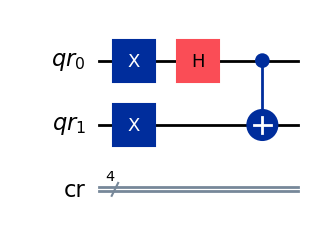

In [36]:
singlet = QuantumCircuit(qr, cr, name='singlet')
singlet.x(qr[0])
singlet.x(qr[1])
singlet.h(qr[0])
singlet.cx(qr[0],qr[1])

singlet.draw('mpl')

### Measurement Circuits

\begin{align*}
 b_i = 1: \quad \vec{a}_1 &= (1,0,0) \quad (X \text{ observable}) &
 b_j^{'} = 1: \quad \vec{b}_1 &= \left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) \quad (W \text{ observable})
 \\
 b_i = 2: \quad \vec{a}_2 &= \left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) \quad (W \text{ observable}) &
 b_j^{'} = 2: \quad \vec{b}_2 &= (0,0,1) \quad ( \text{Z observable})
 \\
 b_i = 3: \quad \vec{a}_3 &= (0,0,1) \quad (Z \text{ observable}) &
 b_j^{'} = 3: \quad \vec{b}_3 &= \left(-\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) \quad (V \text{ observable})
\end{align*}

In [37]:
## Alice's measurement circuits

# measure the spin projection of Alice's qubit onto the a_1 direction (X basis)
measureA1 = QuantumCircuit(qr, cr, name='measureA1')
measureA1.h(qr[0])
measureA1.measure(qr[0],cr[0])

# measure the spin projection of Alice's qubit onto the a_2 direction (W basis)
measureA2 = QuantumCircuit(qr, cr, name='measureA2')
measureA2.s(qr[0])
measureA2.h(qr[0])
measureA2.t(qr[0])
measureA2.h(qr[0])
measureA2.measure(qr[0],cr[0])

# measure the spin projection of Alice's qubit onto the a_3 direction (standard Z basis)
measureA3 = QuantumCircuit(qr, cr, name='measureA3')
measureA3.measure(qr[0],cr[0])

## Bob's measurement circuits

# measure the spin projection of Bob's qubit onto the b_1 direction (W basis)
measureB1 = QuantumCircuit(qr, cr, name='measureB1')
measureB1.s(qr[1])
measureB1.h(qr[1])
measureB1.t(qr[1])
measureB1.h(qr[1])
measureB1.measure(qr[1],cr[1])

# measure the spin projection of Bob's qubit onto the b_2 direction (standard Z basis)
measureB2 = QuantumCircuit(qr, cr, name='measureB2')
measureB2.measure(qr[1],cr[1])

# measure the spin projection of Bob's qubit onto the b_3 direction (V basis)
measureB3 = QuantumCircuit(qr, cr, name='measureB3')
measureB3.s(qr[1])
measureB3.h(qr[1])
measureB3.tdg(qr[1])
measureB3.h(qr[1])
measureB3.measure(qr[1],cr[1])

## Lists of measurement circuits
aliceMeasurements = [measureA1, measureA2, measureA3]
bobMeasurements = [measureB1, measureB2, measureB3]

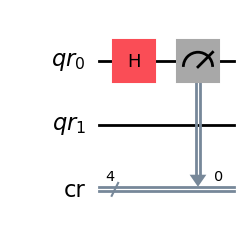

In [38]:
measureA1.draw('mpl')

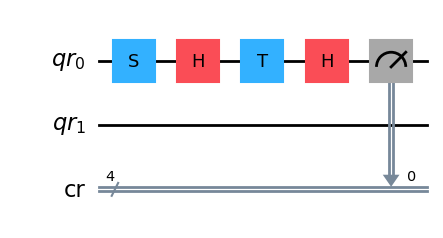

In [39]:
measureA2.draw('mpl')

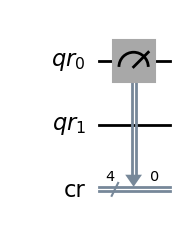

In [40]:
measureA3.draw('mpl')

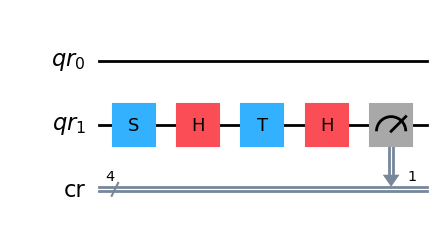

In [41]:
measureB1.draw('mpl')

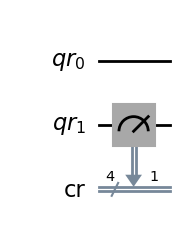

In [42]:
measureB2.draw('mpl')

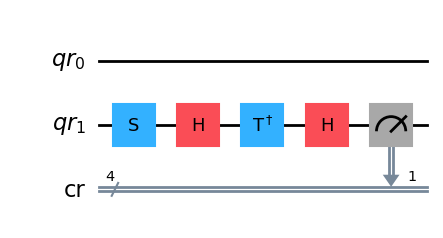

In [43]:
measureB3.draw('mpl')

### QBER Calculation

In [44]:
# QBER Part needs to be added here
def calculate_qber(aliceKey, bobKey, disclose = 10):
    if (len(aliceKey) != len(bobKey)):
        return -1
    key_length = len(aliceKey)
    num_disclosed = max(1, int(np.floor((key_length * disclose/100))))
    disclosed_indices = random.sample(range(key_length), num_disclosed)
    numKeyMismatches = 0
    for i in disclosed_indices:
        if (aliceKey[i] != bobKey[i]):
            numKeyMismatches += 1
    return (numKeyMismatches/num_disclosed) * 100

### CHSH correlation value test

$$C =
\langle X\otimes W \rangle - \langle X \otimes V \rangle + \langle Z \otimes W \rangle + \langle Z \otimes V \rangle =
-2 \sqrt{2}. \qquad\qquad $$

Alice and Bob want to be sure that there was no interference in the communication session.
To do that, they calculate the CHSH correlation value $(3)$ using the results obtained after the measurements of spin projections onto the $\vec{a}_1/\vec{b}_3$, $\vec{a}_1/\vec{b}_4$, $\vec{a}_2/\vec{b}_3$ and $\vec{a}_2/\vec{b}_4$ directions.
Recall that it is equivalent to the measurement of the observables $X \otimes W$, $X \otimes V$, $Z \otimes W$ and $Z \otimes V$ respectively.

$$\langle A(\vec{a}_i) \otimes B(\vec{b}_j) \rangle =
  \mathrm{P}(-1,-1) - \mathrm{P}(1,-1) - \mathrm{P}(-1,1) + \mathrm{P}(1,1). \qquad\qquad$$

$$\mathrm{P}(a_j, b_k) = \frac{n_{a_j, b_k}(A \otimes B)}{N(A \otimes B)} \qquad\qquad$$

In [45]:
# function that calculates CHSH correlation value
def chsh_corr(result, circuits, numberOfSinglets, aliceMeasurementChoices, bobMeasurementChoices, abPatterns):

    # lists with the counts of measurement results
    # each element represents the number of (-1,-1), (-1,1), (1,-1) and (1,1) results respectively
    countA1B1 = [0, 0, 0, 0] # XW observable
    countA1B3 = [0, 0, 0, 0] # XV observable
    countA3B1 = [0, 0, 0, 0] # ZW observable
    countA3B3 = [0, 0, 0, 0] # ZV observable

    for i in range(numberOfSinglets):

        res = list(result.get_counts(circuits[i]).keys())[0]

        # if the spins of the qubits of the i-th singlet were projected onto the a_1/b_1 directions
        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 1):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B1[j] += 1

        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B3[j] += 1

        if (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 1):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA3B1[j] += 1
                    
        # if the spins of the qubits of the i-th singlet were projected onto the a_3/b_3 directions
        if (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA3B3[j] += 1
                    
    # number of the results obtained from the measurements in a particular basis
    total11 = sum(countA1B1)
    total13 = sum(countA1B3)
    total31 = sum(countA3B1)
    total33 = sum(countA3B3)      
                    
    # expectation values of XW, XV, ZW and ZV observables (2)
    expect11 = (countA1B1[0] - countA1B1[1] - countA1B1[2] + countA1B1[3])/total11 # -1/sqrt(2)
    expect13 = (countA1B3[0] - countA1B3[1] - countA1B3[2] + countA1B3[3])/total13 # 1/sqrt(2)
    expect31 = (countA3B1[0] - countA3B1[1] - countA3B1[2] + countA3B1[3])/total31 # -1/sqrt(2)
    expect33 = (countA3B3[0] - countA3B3[1] - countA3B3[2] + countA3B3[3])/total33 # -1/sqrt(2) 
    
    corr = expect11 - expect13 + expect31 + expect33 # calculate the CHSH correlation value (3)
    
    return corr

### Function to simulate the protocol without eavesdropping

In [46]:
def e91_without_eavesdropping(numberOfSinglets = 5500, disclose_rate = 11, log = False):
    # Defining Measurement Choices:
    if (log):
        print("Defining Measurement Choices...")
    aliceMeasurementChoices = [random.randint(1, 3) for i in range(numberOfSinglets)] # string b of Alice
    bobMeasurementChoices = [random.randint(1, 3) for i in range(numberOfSinglets)]
    if (log):
        print("Defining Circuits and Applying Measurement Circuits as per the choices...")
    # Circuits
    circuits = []

    for i in range(numberOfSinglets):
        circuitName = f"Singlet{i}: A{aliceMeasurementChoices[i]}_B{bobMeasurementChoices[i]}"
        singletCircuit = singlet.copy()

        # Retrieve Alice's and Bob's measurement circuits
        aliceCircuitMeasurement = aliceMeasurements[aliceMeasurementChoices[i] - 1]
        bobCircuitMeasurement = bobMeasurements[bobMeasurementChoices[i] - 1]

        singletCircuit.barrier()

        # Combine the circuits (assuming sequential composition)
        singletCircuit = singletCircuit.compose(aliceCircuitMeasurement)
        singletCircuit.barrier()
        singletCircuit = singletCircuit.compose(bobCircuitMeasurement)
        singletCircuit.name = circuitName

        # Add the circuit to the list
        circuits.append(singletCircuit)

    if (log):
        print("Measuring Circuits using a backend simulator...")

    backend = AerSimulator()
    job = backend.run(circuits, shots = 1)
    results = job.result()

    abPatterns = [
        re.compile('..00$'), # search for the '..00' output (Alice obtained -1 and Bob obtained -1)
        re.compile('..01$'), # search for the '..01' output (Alice obtained 1 and Bob obtained -1)
        re.compile('..10$'), # search for the '..10' output (Alice obtained -1 and Bob obtained 1)
        re.compile('..11$')  # search for the '..11' output (Alice obtained 1 and Bob obtained 1)
    ]

    if (log):
        print("Analysing Results...")

    aliceResults = []
    bobResults = []

    for i in range(numberOfSinglets):

        res = list(results.get_counts(circuits[i]).keys())[0] # extract the key from the dict and transform it to str; execution result of the i-th circuit

        if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(-1) # Bob got the result -1
        if abPatterns[1].search(res):
            aliceResults.append(1)
            bobResults.append(-1)
        if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(1) # Bob got the result 1
        if abPatterns[3].search(res):
            aliceResults.append(1)
            bobResults.append(1)

    if (log):
        print("Generating the key...")

    aliceKey = []
    bobKey = []

    # comparing the stings with measurement choices
    for i in range(numberOfSinglets):
        if (aliceMeasurementChoices[i] == 2 and bobMeasurementChoices[i] == 1) or (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 2):
            aliceKey.append(aliceResults[i]) # record the i-th result obtained by Alice as the bit of the secret key k
            bobKey.append(-bobResults[i]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'

    keyLength = len(aliceKey) # length of the secret key

    abKeyMismatches = 0 # number of mismatching bits in Alice's and Bob's keys

    for j in range(keyLength):
        if aliceKey[j] != bobKey[j]:
            abKeyMismatches += 1

    if (log):
        print("Calculating QBER...")

    error_rate = calculate_qber(aliceKey, bobKey)

    if (log):
        print("Calculating Correlation Value...")

    corr = chsh_corr(results, circuits, numberOfSinglets, aliceMeasurementChoices, bobMeasurementChoices, abPatterns) # CHSH correlation value

    if (log):
        print("---------------------")
        print("Protocol Summary: ")
        # Keys
        print(f"Total Number of Qubits Exchanged: " + str(numberOfSinglets))
        print(f"Alice's Key: {aliceKey}")
        print(f"Bob's key: {bobKey}")
        print(f"QBER with disclose rate {disclose_rate}%: {error_rate}")
        print('Length of the key: ' + str(keyLength))
        print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

        # CHSH inequality test
        print('CHSH correlation value: ' + str(round(corr, 3)))

    return keyLength, error_rate, corr

In [47]:
result = e91_without_eavesdropping(log=True)

Defining Measurement Choices...
Defining Circuits and Applying Measurement Circuits as per the choices...
Measuring Circuits using a backend simulator...
Analysing Results...
Generating the key...
Calculating QBER...
Calculating Correlation Value...
---------------------
Protocol Summary: 
Total Number of Qubits Exchanged: 5500
Alice's Key: [1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1,

## Simulation of eavesdropping

### Measurement Circuits

In [48]:
# measurement of the spin projection of Alice's qubit onto the a_2 direction (W basis)
measureEA2 = QuantumCircuit(qr, cr, name='measureEA2')
measureEA2.s(qr[0])
measureEA2.h(qr[0])
measureEA2.t(qr[0])
measureEA2.h(qr[0])
measureEA2.measure(qr[0],cr[2])

# measurement of the spin projection of Alice's qubit onto the a_3 direction (standard Z basis)
measureEA3 = QuantumCircuit(qr, cr, name='measureEA3')
measureEA3.measure(qr[0],cr[2])

# measurement of the spin projection of Bob's qubit onto the b_1 direction (W basis)
measureEB1 = QuantumCircuit(qr, cr, name='measureEB1')
measureEB1.s(qr[1])
measureEB1.h(qr[1])
measureEB1.t(qr[1])
measureEB1.h(qr[1])
measureEB1.measure(qr[1],cr[3])

# measurement of the spin projection of Bob's qubit onto the b_2 direction (standard Z measurement)
measureEB2 = QuantumCircuit(qr, cr, name='measureEB2')
measureEB2.measure(qr[1],cr[3])

# lists of measurement circuits
eveMeasurements = [measureEA2, measureEA3, measureEB1, measureEB2]

### Function to simulate Protocol with eavesdropping

In [49]:
def e91_with_eavesdropping(numberOfSinglets = 5500, disclose_rate = 11, qber_threshold = 0.11, log = False):
    # Defining Measurement Choices:
    if (log):
        print("Defining Measurement Choices...")

    aliceMeasurementChoices = [random.randint(1, 3) for i in range(numberOfSinglets)] # string b of Alice
    bobMeasurementChoices = [random.randint(1, 3) for i in range(numberOfSinglets)] # string b' of Bob

    if (log):
        print("Defining Circuits and Applying Measurement Circuits as per the choices...")

    # Circuits
    ABECircuits = []
    attack_probability = 4 * qber_threshold
    num_intercepts = 0
    intercepted_qubit_indices = []

    for j in range(numberOfSinglets):
        eveMeasurementChoices = []
        SingletCircuitABE = singlet.copy()
        eve_intercepts = np.random.rand() < attack_probability
        if (eve_intercepts):
            num_intercepts += 1
            intercepted_qubit_indices.append(j)
            if random.uniform(0, 1) <= 0.5: # in 50% of cases perform the XX measurement
                eveMeasurementChoices.append([0, 2])
            else:
                eveMeasurementChoices.append([1, 3])
            SingletCircuitABE.barrier()
            SingletCircuitABE = SingletCircuitABE.compose(eveMeasurements[eveMeasurementChoices[0][0]])
            SingletCircuitABE.barrier()
            SingletCircuitABE = SingletCircuitABE.compose(eveMeasurements[eveMeasurementChoices[0][1]])
            SingletCircuitABE.barrier()
            circuitName = f"SingletABE{j}:A{aliceMeasurementChoices[j]}_B{bobMeasurementChoices[j]}_E{eveMeasurementChoices[0][0]}{eveMeasurementChoices[0][1]}"
        else:
            circuitName = f"SingletABE{j}:A{aliceMeasurementChoices[j]}_B{bobMeasurementChoices[j]}_NoEavesdropping"

        SingletCircuitABE = SingletCircuitABE.compose(aliceMeasurements[aliceMeasurementChoices[j] - 1])
        SingletCircuitABE.barrier()
        SingletCircuitABE = SingletCircuitABE.compose(bobMeasurements[bobMeasurementChoices[j] - 1])

        SingletCircuitABE.name = circuitName
        # add the created circuit to the circuits list
        ABECircuits.append(SingletCircuitABE)

    if (log):
        print("Measuring Circuits using a backend simulator...")

    backend = AerSimulator()
    Eavesdropping_results = backend.run(ABECircuits, shots = 1).result()

    ePatterns = [
        re.compile('00..$'), # search for the '00..' result (Eve obtained the results -1 and -1 for Alice's and Bob's qubits)
        re.compile('01..$'), # search for the '01..' result (Eve obtained the results 1 and -1 for Alice's and Bob's qubits)
        re.compile('10..$'), # search for the '10..' result (Eve obtained the results -1 and 1 for Alice's and Bob's qubits)
        re.compile('11..$')  # search for the '11..' result (Eve obtained the results 1 and 1 for Alice's and Bob's qubits)
    ]

    abPatterns = [
        re.compile('..00$'), # search for the '..00' output (Alice obtained -1 and Bob obtained -1)
        re.compile('..01$'), # search for the '..01' output (Alice obtained 1 and Bob obtained -1)
        re.compile('..10$'), # search for the '..10' output (Alice obtained -1 and Bob obtained 1)
        re.compile('..11$')  # search for the '..11' output (Alice obtained 1 and Bob obtained 1)
    ]

    if (log):
        print("Analysing Results...")

    aliceResults = []
    bobResults = []
    eveResults = []

    for j in range(numberOfSinglets):
        res = list(Eavesdropping_results.get_counts(ABECircuits[j]).keys())[0] # extract a key from the dict and transform it to str
        # Alice and Bob
        if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(-1) # Bob got the result -1
        if abPatterns[1].search(res): # check if the key is '..01' (if the measurement results are 1,-1)
            aliceResults.append(1)
            bobResults.append(-1)
        if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
            aliceResults.append(-1) # Alice got the result -1
            bobResults.append(1) # Bob got the result 1
        if abPatterns[3].search(res): # check if the key is '..11' (if the measurement results are 1,1)
            aliceResults.append(1)
            bobResults.append(1)

        # Eve
        if ePatterns[0].search(res): # check if the key is '00..'
            eveResults.append([-1, -1]) # results of the measurement of Alice's and Bob's qubits are -1,-1
        if ePatterns[1].search(res): # check if the key is '01..'
            eveResults.append([1, -1]) # results of the measurement of Alice's and Bob's qubits are 1,-1
        if ePatterns[2].search(res): # check if the key is '10..'
            eveResults.append([-1, 1]) # results of the measurement of Alice's and Bob's qubits are -1,1
        if ePatterns[3].search(res): # check if the key is '11..'
            eveResults.append([1, 1]) # results of the measurement of Alice's and Bob's qubits are 1,1

    if (log):
        print("Generating the key...")

    aliceKey = [] # Alice's key string a
    bobKey = [] # Bob's key string a'
    eveKeys = [] # Eve's keys; the 1-st column is the key of Alice, and the 2-nd is the key of Bob

    keyIndices = [] # Indices of Qubits used for the key
    key_index_with_intercepted_qubit = [] # Indices of Alice's and Bob's Key which was formed using the qubits that was intercepted by Eve
    idx = 0
    # comparing the strings with measurement choices (b and b')
    for j in range(numberOfSinglets):
        # if Alice and Bob measured the spin projections onto the a_2/b_1 or a_3/b_2 directions
        if (aliceMeasurementChoices[j] == 2 and bobMeasurementChoices[j] == 1) or (aliceMeasurementChoices[j] == 3 and bobMeasurementChoices[j] == 2):
            keyIndices.append(j)
            if j in intercepted_qubit_indices:
                key_index_with_intercepted_qubit.append(idx)
                eveKeys.append([eveResults[j][0], -eveResults[j][1]]) # record the i-th bits of the keys of Eve
            aliceKey.append(aliceResults[j]) # record the i-th result obtained by Alice as the bit of the secret key k
            bobKey.append(-bobResults[j]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'
            idx += 1

    keyLength = len(aliceKey) # length of the secret key

    if (log):
        print("Calculating Key Mismatches...")

    abKeyMismatches = 0 # number of mismatching bits in the keys of Alice and Bob
    eaKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Alice
    ebKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Bob

    for j in range(keyLength):
        if aliceKey[j] != bobKey[j]:
            abKeyMismatches += 1

    for j in range(len(key_index_with_intercepted_qubit)):
        if eveKeys[j][0] != aliceKey[key_index_with_intercepted_qubit[j]]:
            eaKeyMismatches += 1
        if eveKeys[j][1] != bobKey[key_index_with_intercepted_qubit[j]]:
            ebKeyMismatches += 1

    num_intercepts_used_in_key = len(key_index_with_intercepted_qubit);

    if (log):
        print("Calculating Eve's Knowledge of Alice's and Bob's Keys...")
    eaKnowledge = (num_intercepts_used_in_key - eaKeyMismatches)/num_intercepts_used_in_key # Eve's knowledge of Alice's key
    ebKnowledge = (num_intercepts_used_in_key - ebKeyMismatches)/num_intercepts_used_in_key # Eve's knowledge of Bob's key

    if (log):
        print("Calculating QBER...")
    error_rate = calculate_qber(aliceKey, bobKey)

    if (log):
        print("Calculating Correlation Value...")
    corr = chsh_corr(Eavesdropping_results, ABECircuits, numberOfSinglets, aliceMeasurementChoices, bobMeasurementChoices, abPatterns) # CHSH correlation value

    if (log):
        print("---------------------")
        print("Protocol Summary: ")
        print("Number of Qubits: " + str(numberOfSinglets))
        # Keys
        print('Length of the key: ' + str(keyLength))
        print('Number of mismatching bits: ' + str(abKeyMismatches))
        print(f"QBER with disclose rate of {disclose_rate}%: {error_rate}" + '\n')

        print('Number of qubits intercepted: ' + str(num_intercepts))
        print('Number of intercepted qubits used in the key: ' + str(num_intercepts_used_in_key) + "\n")

        # CHSH inequality test
        print('CHSH correlation value: ' + str(round(corr, 3)) + '\n')

        print('Eve Alice Key mismatches: ' + str(eaKeyMismatches))
        print('Eve Bob Key mismatches: ' + str(ebKeyMismatches) + '\n')

        print('Eve\'s knowledge of Alice\'s key: ' + str(round(eaKnowledge * 100, 2)) + ' %')
        print('Eve\'s knowledge of Bob\'s key: ' + str(round(ebKnowledge * 100, 2)) + ' %')

    return keyLength, error_rate, corr, eaKnowledge, ebKnowledge, num_intercepts_used_in_key, eaKeyMismatches, ebKeyMismatches, abKeyMismatches, num_intercepts


In [50]:
result = e91_with_eavesdropping(numberOfSinglets=5500, log=True)

Defining Measurement Choices...
Defining Circuits and Applying Measurement Circuits as per the choices...
Measuring Circuits using a backend simulator...
Analysing Results...
Generating the key...
Calculating Key Mismatches...
Calculating Eve's Knowledge of Alice's and Bob's Keys...
Calculating QBER...
Calculating Correlation Value...
---------------------
Protocol Summary: 
Number of Qubits: 5500
Length of the key: 1223
Number of mismatching bits: 68
QBER with disclose rate of 11%: 9.01639344262295

Number of qubits intercepted: 2373
Number of intercepted qubits used in the key: 553

CHSH correlation value: -2.194

Eve Alice Key mismatches: 47
Eve Bob Key mismatches: 35

Eve's knowledge of Alice's key: 91.5 %
Eve's knowledge of Bob's key: 93.67 %


### Metrics

In [51]:
number_of_qubits = np.linspace(1000, 6000, 11)
e91_abMismatches = []
e91_num_intercepted_and_in_key = []
e91_eaMismatches = []
e91_ebMismatches = []
e91_keyLengths = []
eve_alice_knowledge = []
eve_bob_knowledge = []
e91_num_intercepts = []
for i in range(len(number_of_qubits)):
    result = e91_with_eavesdropping(numberOfSinglets=int(number_of_qubits[i]))
    eve_alice_knowledge.append(result[3])
    eve_bob_knowledge.append(result[4])
    e91_num_intercepted_and_in_key.append(result[5])
    e91_eaMismatches.append(result[6])
    e91_ebMismatches.append(result[7])
    e91_keyLengths.append(result[0])
    e91_abMismatches.append(result[8])
    e91_num_intercepts.append(result[9])
    print(f"Circuit {i} done")

Circuit 0 done
Circuit 1 done
Circuit 2 done
Circuit 3 done
Circuit 4 done
Circuit 5 done
Circuit 6 done
Circuit 7 done
Circuit 8 done
Circuit 9 done
Circuit 10 done


In [52]:
print(f"Number of qubits: {number_of_qubits}")
print(f"Key Lengths: {e91_keyLengths}")
print(f"E-A Mismatches: {e91_eaMismatches}")
print(f"E-B Mismatches: {e91_ebMismatches}")
print(f"A-B Mismatches: {e91_abMismatches}")
print(f"Number of qubits intercepted: {e91_num_intercepts}")
print(f"Number of qubits intercepted by Eve and is in the key: {e91_num_intercepted_and_in_key}")

Number of qubits: [1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500. 5000. 5500. 6000.]
Key Lengths: [224, 330, 437, 538, 704, 800, 847, 1032, 1075, 1202, 1362]
E-A Mismatches: [13, 11, 11, 22, 22, 26, 30, 31, 40, 28, 35]
E-B Mismatches: [12, 12, 8, 19, 31, 28, 27, 28, 36, 42, 53]
A-B Mismatches: [21, 21, 19, 35, 49, 50, 53, 53, 62, 62, 74]
Number of qubits intercepted: [434, 630, 899, 1114, 1333, 1531, 1750, 2012, 2209, 2411, 2651]
Number of qubits intercepted by Eve and is in the key: [109, 156, 182, 239, 303, 356, 371, 444, 469, 526, 584]


# BB84 Protocol

## Simulation Without the Presence of an Eavesdropper

In [53]:
# Creating registers
qr = QuantumRegister(1, name="qr")
cr = ClassicalRegister(2, name="cr")

Qubits *qr\[0\]* refers to the qubit transmitted.
Classical bit *cr\[0\]* is used by Bob to store his measurement value.
Classical bit *cr\[1\]* is used by Eve to store her measurement result of the qubit transmitted.

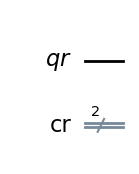

In [54]:
qc = QuantumCircuit(qr, cr, name='qc')
qc.draw('mpl')

### QBER Calculation

In [55]:
# QBER Part needs to be added here
def calculate_qber(aliceKey, bobKey, disclose = 10):
    if (len(aliceKey) != len(bobKey)):
        return -1
    key_length = len(aliceKey)
    num_disclosed = max(1, int(np.floor((key_length * disclose/100))))
    disclosed_indices = random.sample(range(key_length), num_disclosed)
    numKeyMismatches = 0
    for i in disclosed_indices:
        if (aliceKey[i] != bobKey[i]):
            numKeyMismatches += 1
    return (numKeyMismatches/num_disclosed) * 100

### Function to simulate the protocol without eavesdropping

In [56]:
def bb84_without_eavesdropping(length = 5500, disclose_rate = 11, log = False):
    # Generating Random Bit String (Used for Raw Key) string s_A
    if (log):
        print("Generating Random Bit String for Raw Key: ")
    bitString = [random.randint(0, 1) for _ in range(length)]

    # Defining Measurement Strings for Alice and Bob:
    if (log):
        print("Defining Measurement Choices...")
    aliceMeasurementString = [random.randint(0, 1) for _ in range(length)] # string m_A of Alice
    bobMeasurementString = [random.randint(0, 1) for _ in range(length)] # string m_B of Bob

    if (log):
        print("Defining Circuits and Applying Measurements as per the string...")
    # Circuits
    circuits = []
    for i in range(length):
        circuitName = f"Singlet{i}: A{aliceMeasurementString[i]}_B{bobMeasurementString[i]}"
        circ = qc.copy()

        # Alice's Encoding of Random Bit String (s_A)
        if (bitString[i] == 1):
            circ.x(qr[0])
        if (aliceMeasurementString[i] == '1'):
            circ.h(qr[0])

        circ.barrier()

        # Bob's measurement of qubits
        if (bobMeasurementString[i] == '1'):
            circ.h(qr[0])
        
        circ.measure(qr[0], cr[0])

        circ.name = circuitName
        
        # Add the circuit to the list
        circuits.append(circ)

    if (log):
        print("Measuring Circuits using a backend simulator...")

    backend = AerSimulator()
    job = backend.run(circuits, shots = 1)
    results = job.result()

    abPatterns = [
        re.compile('.0$'),
        re.compile('.1$')
    ]

    if (log):
        print("Analysing Results...")

    bobResults = []

    for i in range(length):

        res = list(results.get_counts(circuits[i]).keys())[0] # extract the key from the dict and transform it to str; execution result of the i-th circuit

        if abPatterns[0].search(res):
            bobResults.append(0)
        if abPatterns[1].search(res):
            bobResults.append(1)

    if (log):
        print("Generating the key...")

    aliceKey = []
    bobKey = []

    # comparing the stings with measurement choices
    for i in range(length):
        if (aliceMeasurementString[i] == bobMeasurementString[i]):
            aliceKey.append(bitString[i]) 
            bobKey.append(bobResults[i])

    keyLength = len(aliceKey) # length of the secret key

    abKeyMismatches = 0 # number of mismatching bits in Alice's and Bob's keys

    for j in range(keyLength):
        if aliceKey[j] != bobKey[j]:
            abKeyMismatches += 1

    if (log):
        print("Calculating QBER...")

    error_rate = calculate_qber(aliceKey, bobKey)

    if (log):
        print("---------------------")
        print("Protocol Summary: ")
        # Keys
        print(f"Total Number of Qubits Exchanged: " + str(length))
        print(f"Alice's Key: {aliceKey}")
        print(f"Bob's key: {bobKey}")
        print(f"QBER with disclose rate {disclose_rate}%: {error_rate}")
        print('Length of the key: ' + str(keyLength))
        print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

    return keyLength, error_rate

In [57]:
result = bb84_without_eavesdropping(log=True)

Generating Random Bit String for Raw Key: 
Defining Measurement Choices...
Defining Circuits and Applying Measurements as per the string...
Measuring Circuits using a backend simulator...
Analysing Results...
Generating the key...
Calculating QBER...
---------------------
Protocol Summary: 
Total Number of Qubits Exchanged: 5500
Alice's Key: [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0

## Simulation of eavesdropping

### Measurement Circuits

In [58]:
measureE1 = QuantumCircuit(qr, cr, name='measureE1')
measureE1.measure(qr[0],cr[1])

measureE2 = QuantumCircuit(qr, cr, name='measureE2')
measureE2.h(qr[0])
measureE2.measure(qr[0],cr[1])
measureE2.h(qr[0])

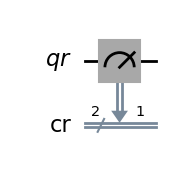

In [59]:
measureE1.draw('mpl')

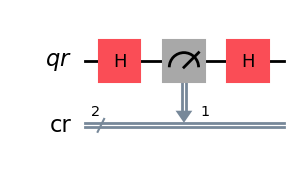

In [60]:
measureE2.draw('mpl')

### Function to simulate Protocol with eavesdropping

In [61]:
def bb84_with_eavesdropping(length = 5500, disclose_rate = 11, qber_threshold = 0.11, log = False):
    # Generating Random Bit String (Used for Raw Key) string s_A
    if (log):
        print("Generating Random Bit String for Raw Key: ")
    bitString = [random.randint(0, 1) for _ in range(length)]

    # Defining Measurement Strings for Alice and Bob:
    if (log):
        print("Defining Measurement Choices...")
    aliceMeasurementString = [random.randint(0, 1) for _ in range(length)] # string m_A of Alice
    bobMeasurementString = [random.randint(0, 1) for _ in range(length)] # string m_B of Bob

    if (log):
        print("Defining Circuits and Applying Measurements as per the string...")
    # Circuits
    circuits = []
    attack_probability = 4 * qber_threshold
    intercepted_qubit_indices = []
    num_intercepts = 0
    for i in range(length):
        circuitName = ""
        circ = qc.copy()

        # Alice's Encoding of Random Bit String (s_A)
        if (bitString[i] == 1):
            circ.x(qr[0])
        if (aliceMeasurementString[i] == '1'):
            circ.h(qr[0])

        circ.barrier()
        eve_intercepts = np.random.rand() < attack_probability
        if (eve_intercepts):
            num_intercepts += 1
            intercepted_qubit_indices.append(i)
            if random.uniform(0, 1) <= 0.5:
                circ = circ.compose(measureE1)
            else:
                circ = circ.compose(measureE2)
            circ.barrier()
            circuitName = f"SingletABE{i}:A{aliceMeasurementString[i]}_B{bobMeasurementString[i]}_E"
        else:
            circuitName = f"SingletABE{i}:A{aliceMeasurementString[i]}_B{bobMeasurementString[i]}_NoE"
        

        # Bob's measurement of qubits
        if (bobMeasurementString[i] == '1'):
            circ.h(qr[0])
        
        circ.measure(qr[0], cr[0])

        circ.name = circuitName
        circuits.append(circ)

    if (log):
        print("Measuring Circuits using a backend simulator...")

    backend = AerSimulator()
    Eavesdropping_results = backend.run(circuits, shots = 1).result()

    ePatterns = [
        re.compile('0.$'),
        re.compile('1.$')
    ]

    abPatterns = [
        re.compile('.0$'),
        re.compile('.1$')
    ]

    if (log):
        print("Analysing Results...")

    bobResults = []
    eveResults = []

    for j in range(length):
        res = list(Eavesdropping_results.get_counts(circuits[j]).keys())[0] # extract a key from the dict and transform it to str
        # Alice and Bob
        if abPatterns[0].search(res):
            bobResults.append(0) 
        if abPatterns[1].search(res):
            bobResults.append(1)

        # Eve
        if ePatterns[0].search(res):
            eveResults.append(0) 
        if ePatterns[1].search(res): 
            eveResults.append(1)

    if (log):
        print("Generating the key...")

    aliceKey = [] # Alice's key string a
    bobKey = [] # Bob's key string a'
    eveKey = [] 

    keyIndices = [] # Indices of Qubits used for the key
    key_index_with_intercepted_qubit = [] # Indices of Alice's and Bob's Key which was formed using the qubits that was intercepted by Eve
    idx = 0
    # comparing the strings with measurement choices (b and b')
    for j in range(length):
        # if Alice and Bob measured the spin projections onto the a_2/b_1 or a_3/b_2 directions
        if (aliceMeasurementString[j] == bobMeasurementString[j]):
            keyIndices.append(j)
            if j in intercepted_qubit_indices:
                key_index_with_intercepted_qubit.append(idx)
                eveKey.append(eveResults[j])
            aliceKey.append(bitString[j]) 
            bobKey.append(bobResults[j])
            idx += 1

    keyLength = len(aliceKey) # length of the secret key

    if (log):
        print("Calculating Key Mismatches...")

    abKeyMismatches = 0 # number of mismatching bits in the keys of Alice and Bob
    eaKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Alice
    ebKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Bob

    for j in range(keyLength):
        if aliceKey[j] != bobKey[j]:
            abKeyMismatches += 1

    for j in range(len(key_index_with_intercepted_qubit)):
        if eveKey[j] != aliceKey[key_index_with_intercepted_qubit[j]]:
            eaKeyMismatches += 1
        if eveKey[j] != bobKey[key_index_with_intercepted_qubit[j]]:
            ebKeyMismatches += 1

    num_intercepts_used_in_key = len(key_index_with_intercepted_qubit);

    if (log):
        print("Calculating Eve's Knowledge of Alice's and Bob's Keys...")
    eaKnowledge = (num_intercepts_used_in_key - eaKeyMismatches)/num_intercepts_used_in_key # Eve's knowledge of Alice's key
    ebKnowledge = (num_intercepts_used_in_key - ebKeyMismatches)/num_intercepts_used_in_key # Eve's knowledge of Bob's key

    if (log):
        print("Calculating QBER...")
    error_rate = calculate_qber(aliceKey, bobKey)

    if (log):
        print("---------------------")
        print("Protocol Summary: ")
        print("Number of Qubits: " + str(length))
        # Keys
        print('Length of the key: ' + str(keyLength))
        print('Number of mismatching bits: ' + str(abKeyMismatches))
        print(f"QBER with disclose rate of {disclose_rate}%: {error_rate}" + '\n')

        print('Number of qubits intercepted: ' + str(num_intercepts))
        print('Number of intercepted qubits used in the key: ' + str(num_intercepts_used_in_key) + "\n")

        print('Eve Alice Key mismatches: ' + str(eaKeyMismatches))
        print('Eve Bob Key mismatches: ' + str(ebKeyMismatches) + '\n')

        print('Eve\'s knowledge of Alice\'s key: ' + str(round(eaKnowledge * 100, 2)) + ' %')
        print('Eve\'s knowledge of Bob\'s key: ' + str(round(ebKnowledge * 100, 2)) + ' %')

    return keyLength, error_rate, eaKnowledge, ebKnowledge, num_intercepts_used_in_key, eaKeyMismatches, ebKeyMismatches, abKeyMismatches, num_intercepts


In [62]:
result = bb84_with_eavesdropping(length=5500, log=True)

Generating Random Bit String for Raw Key: 
Defining Measurement Choices...
Defining Circuits and Applying Measurements as per the string...
Measuring Circuits using a backend simulator...
Analysing Results...
Generating the key...
Calculating Key Mismatches...
Calculating Eve's Knowledge of Alice's and Bob's Keys...
Calculating QBER...
---------------------
Protocol Summary: 
Number of Qubits: 5500
Length of the key: 2758
Number of mismatching bits: 298
QBER with disclose rate of 11%: 10.545454545454545

Number of qubits intercepted: 2387
Number of intercepted qubits used in the key: 1177

Eve Alice Key mismatches: 291
Eve Bob Key mismatches: 303

Eve's knowledge of Alice's key: 75.28 %
Eve's knowledge of Bob's key: 74.26 %


### Metrics

In [63]:
number_of_qubits = np.linspace(1000, 6000, 11)
bb84_abMismatches = []
bb84_num_intercepted_and_in_key = []
bb84_eaMismatches = []
bb84_ebMismatches = []
bb84_keyLengths = []
eve_alice_knowledge = []
eve_bob_knowledge = []
bb84_num_intercepts = []
for i in range(len(number_of_qubits)):
    result = bb84_with_eavesdropping(length=int(number_of_qubits[i]))
    eve_alice_knowledge.append(result[2])
    eve_bob_knowledge.append(result[3])
    bb84_num_intercepted_and_in_key.append(result[4])
    bb84_eaMismatches.append(result[5])
    bb84_ebMismatches.append(result[6])
    bb84_keyLengths.append(result[0])
    bb84_abMismatches.append(result[7])
    bb84_num_intercepts.append(result[8])
    print(f"Circuit {i} done")

Circuit 0 done
Circuit 1 done
Circuit 2 done
Circuit 3 done
Circuit 4 done
Circuit 5 done
Circuit 6 done
Circuit 7 done
Circuit 8 done
Circuit 9 done
Circuit 10 done


In [64]:
print(f"Number of qubits: {number_of_qubits}")
print(f"Key Lengths: {bb84_keyLengths}")
print(f"E-A Mismatches: {bb84_eaMismatches}")
print(f"E-B Mismatches: {bb84_ebMismatches}")
print(f"A-B Mismatches: {bb84_abMismatches}")
print(f"Number of qubits intercepted: {bb84_num_intercepts}")
print(f"Number of qubits intercepted by Eve and is in the key: {bb84_num_intercepted_and_in_key}")

Number of qubits: [1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500. 5000. 5500. 6000.]
Key Lengths: [497, 758, 1004, 1273, 1518, 1776, 1978, 2249, 2468, 2695, 2968]
E-A Mismatches: [48, 84, 113, 123, 169, 190, 218, 226, 286, 288, 342]
E-B Mismatches: [56, 78, 116, 165, 172, 190, 231, 218, 274, 308, 337]
A-B Mismatches: [58, 78, 95, 144, 163, 192, 215, 226, 280, 294, 345]
Number of qubits intercepted: [449, 665, 826, 1098, 1285, 1545, 1764, 1970, 2187, 2407, 2648]
Number of qubits intercepted by Eve and is in the key: [229, 331, 421, 570, 651, 766, 854, 955, 1093, 1176, 1326]


# Graphs

In [68]:
number_of_qubits = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]
len(number_of_qubits)

11

In [71]:
def calc_percentage(list):
    newList = [(list[i]/number_of_qubits[i]) * 100 for i in range(len(number_of_qubits))]
    return sum(newList)/len(newList)

In [72]:
keyLengths = [calc_percentage(bb84_keyLengths), calc_percentage(e91_keyLengths), calc_percentage(bbm92_keyLengths), calc_percentage(bbm92M_keyLengths)]
E_AMismatches = [calc_percentage(bb84_eaMismatches), calc_percentage(e91_eaMismatches), calc_percentage(bbm92_eaMismatches), calc_percentage(bbm92M_eaMismatches)]
E_BMismatches = [calc_percentage(bb84_ebMismatches), calc_percentage(e91_ebMismatches), calc_percentage(bbm92_ebMismatches), calc_percentage(bbm92M_ebMismatches)]
A_BMismatches = [calc_percentage(bb84_abMismatches), calc_percentage(e91_abMismatches), calc_percentage(bbm92_abMismatches), calc_percentage(bbm92M_abMismatches)]
Num_Intercepts = [calc_percentage(bb84_num_intercepts), calc_percentage(e91_num_intercepts), calc_percentage(bbm92_num_intercepts), calc_percentage(bbm92M_num_intercepts)]
Num_Intercepts_And_In_Key = [calc_percentage(bb84_num_intercepted_and_in_key), calc_percentage(e91_num_intercepted_and_in_key), calc_percentage(bbm92_num_intercepted_and_in_key), calc_percentage(bbm92M_num_intercepted_and_in_key)]

In [73]:
categories = ['BB84', 'E91', 'BBM92', 'Modified BBM92']

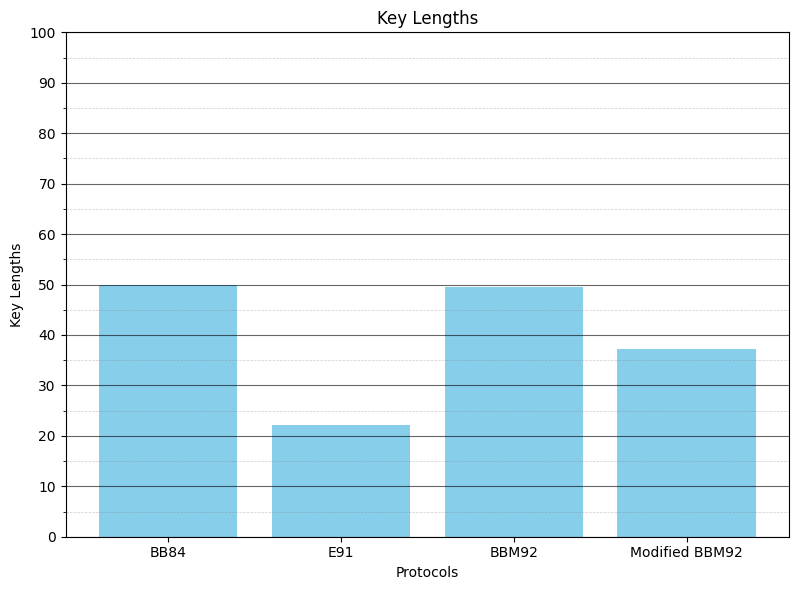

In [74]:
# Create the bar graph
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(categories, keyLengths, color='skyblue')

# Add labels and title
ax.set_xlabel('Protocols')
ax.set_ylabel('Key Lengths')
ax.set_title('Key Lengths')

# Show the plot
plt.tight_layout() # Adjust layout to prevent labels from overlapping
ax.set_ylim(0, 100)

# Set major y-axis ticks every 5 units
ax.yaxis.set_major_locator(tck.MultipleLocator(10))

# Optionally set minor ticks every 1 unit
ax.yaxis.set_minor_locator(tck.MultipleLocator(5))

# Enable light grid lines for minor ticks
ax.yaxis.grid(True, which='minor', linestyle='--', color='gray', alpha=0.4, linewidth=0.5)

# (Optional) Enable major grid too for context
ax.yaxis.grid(True, which='major', linestyle='-', color='black', alpha=0.6, linewidth=0.8)
plt.show()

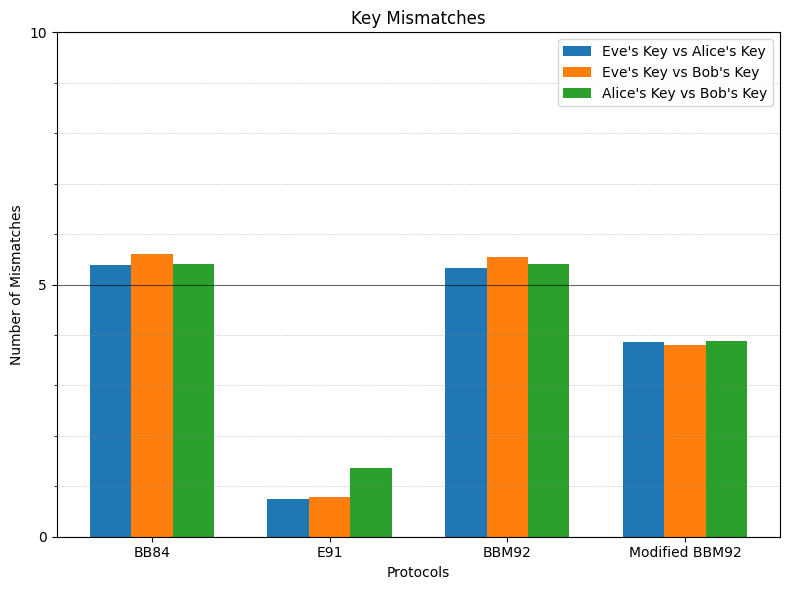

In [75]:
# --- Start of Plotting ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35 # Width of each individual bar
r1 = np.arange(len(categories)) * 1.5 # X-axis positions for the first set of bars
r2 = [x + bar_width for x in r1] # X-axis positions for the second set of bars
r3 = [x + 2 * bar_width for x in r1] # X-axis positions for the second set of bars

# Create the bars for E_AMismatches (shifted left)
ax.bar(r1, E_AMismatches, width=bar_width, label="Eve's Key vs Alice's Key")

# Create the bars for E_BMismatches (shifted right)
ax.bar(r2, E_BMismatches, width=bar_width, label="Eve's Key vs Bob's Key")

ax.bar(r3, A_BMismatches, width=bar_width, label="Alice's Key vs Bob's Key")

# Add labels and title
ax.set_xlabel('Protocols')
ax.set_ylabel('Number of Mismatches')
ax.set_title("Key Mismatches")

# Set x-axis ticks to be in the center of the grouped bars
ax.set_xticks([r + bar_width for r in r1])
ax.set_xticklabels(categories)

# Add a legend to distinguish the bars
ax.legend()

# Set y-axis limits and ticks
ax.set_ylim(0, 10) # Set max y-limit to 10

# Set major y-axis ticks every 5 units (e.g., 0, 5, 10)
ax.yaxis.set_major_locator(tck.MultipleLocator(5)) # Changed to 5 for better distribution within 0-10

# Optionally set minor ticks every 1 unit
ax.yaxis.set_minor_locator(tck.MultipleLocator(1))

# Enable light grid lines for minor ticks
ax.yaxis.grid(True, which='minor', linestyle='--', color='gray', alpha=0.4, linewidth=0.5)

# Enable major grid for context
ax.yaxis.grid(True, which='major', linestyle='-', color='black', alpha=0.6, linewidth=0.8)

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Show the plot
plt.show()

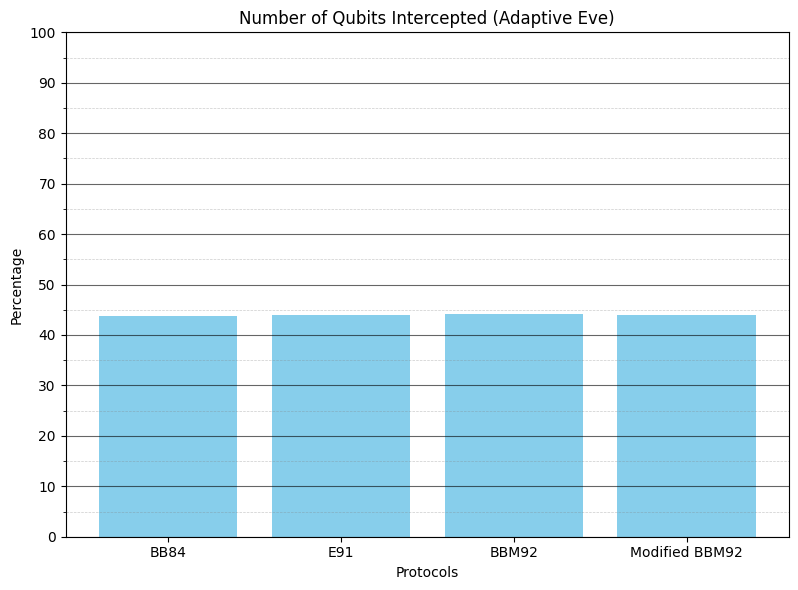

In [76]:
# Create the bar graph
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(categories, Num_Intercepts, color='skyblue')

# Add labels and title
ax.set_xlabel('Protocols')
ax.set_ylabel('Percentage')
ax.set_title('Number of Qubits Intercepted (Adaptive Eve)')

# Show the plot
plt.tight_layout() # Adjust layout to prevent labels from overlapping
ax.set_ylim(0, 100)

# Set major y-axis ticks every 5 units
ax.yaxis.set_major_locator(tck.MultipleLocator(10))

# Optionally set minor ticks every 1 unit
ax.yaxis.set_minor_locator(tck.MultipleLocator(5))

# Enable light grid lines for minor ticks
ax.yaxis.grid(True, which='minor', linestyle='--', color='gray', alpha=0.4, linewidth=0.5)

# (Optional) Enable major grid too for context
ax.yaxis.grid(True, which='major', linestyle='-', color='black', alpha=0.6, linewidth=0.8)
plt.show()

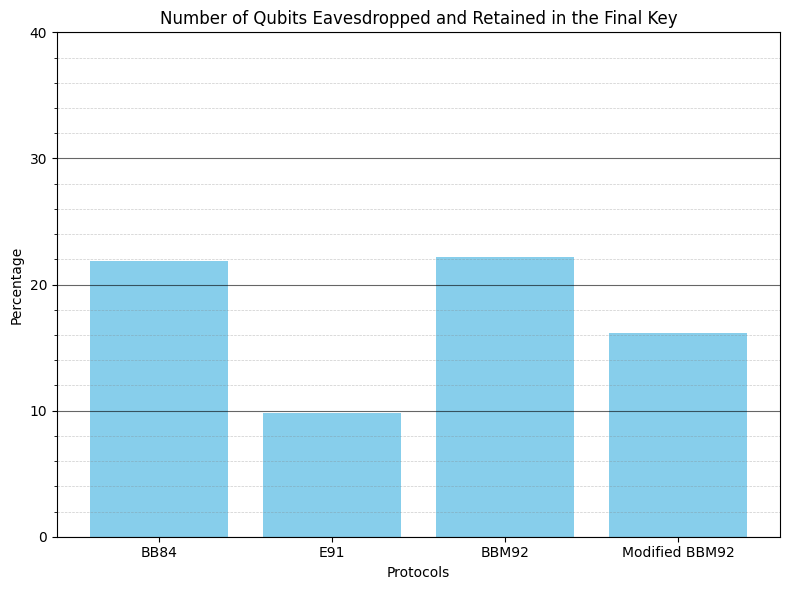

In [77]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(categories, Num_Intercepts_And_In_Key, color='skyblue')
ax.set_xlabel('Protocols')
ax.set_ylabel('Percentage')
ax.set_title('Number of Qubits Eavesdropped and Retained in the Final Key')


plt.tight_layout()
ax.set_ylim(0, 40)

ax.yaxis.set_major_locator(tck.MultipleLocator(10))
ax.yaxis.set_minor_locator(tck.MultipleLocator(2))
ax.yaxis.grid(True, which='minor', linestyle='--', color='gray', alpha=0.4, linewidth=0.5)
ax.yaxis.grid(True, which='major', linestyle='-', color='black', alpha=0.6, linewidth=0.8)
plt.show()